In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
model_version = 'v15.0'

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"../data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 43)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2816      
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 Dropout_256 (Dropout)       (None, 256)          

In [11]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.5,
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
1222/1222 [==============================] - 10s 7ms/step - loss: 15.8348 - mae: 1.5888 - mse: 15.3630 - mape: 15.0750 - val_loss: 1.1077 - val_mae: 0.4217 - val_mse: 0.6585 - val_mape: 3.9840
Epoch 2/200
1222/1222 [==============================] - 8s 7ms/step - loss: 1.7567 - mae: 0.8463 - mse: 1.3256 - mape: 8.0164 - val_loss: 0.5375 - val_mae: 0.1826 - val_mse: 0.1221 - val_mape: 1.7756
Epoch 3/200
1222/1222 [==============================] - 9s 8ms/step - loss: 1.1803 - mae: 0.6853 - mse: 0.7787 - mape: 6.4949 - val_loss: 0.4513 - val_mae: 0.1417 - val_mse: 0.0632 - val_mape: 1.3880
Epoch 4/200
1222/1222 [==============================] - 9s 8ms/step - loss: 0.9620 - mae: 0.6047 - mse: 0.5884 - mape: 5.7329 - val_loss: 0.4181 - val_mae: 0.1377 - val_mse: 0.0590 - val_mape: 1.3495
Epoch 5/200
1222/1222 [==============================] - 9s 8ms/step - loss: 0.8800 - mae: 0.5626 - mse: 0.5365 - mape: 5.3328 - val_loss: 0.3823 - val_mae: 0.1594 - val_mse: 0.0540 - val_mape

In [12]:
model.save(f'../models/{model_version}/spec_photo_model.h5')

In [13]:
save_history(history, model_version)

In [9]:
model = keras.models.load_model(f'../models/{model_version}/spec_photo_model.h5')

In [10]:
y_pred_full = model.predict(X_test_scaled)

2090/2090 [==============================] - 3s 1ms/step


In [11]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0929
Root Mean Squared Error (RMSE): 0.1559
R² Score: 0.9437


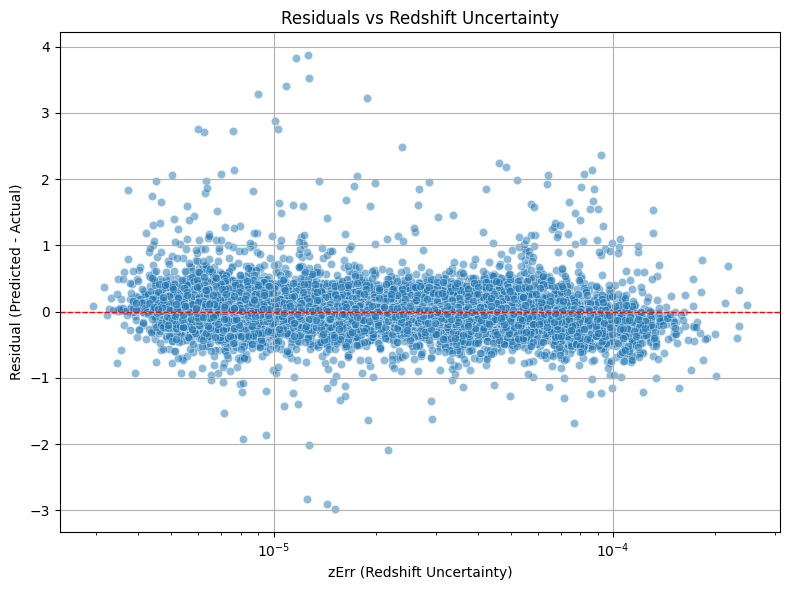

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df contains actual and predicted stellar masses
df_clean = df[df['zErr'] > 0]  # Remove invalid or negative zErr values

# Calculate residuals
residuals = y_pred_full - y_test
X_test['residual'] = residuals
# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_test, x='zErr', y='residual', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("zErr (Redshift Uncertainty)")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residuals vs Redshift Uncertainty")
plt.xscale('log')  # Optional if zErr spans orders of magnitude
plt.grid(True)
plt.tight_layout()
plt.show()

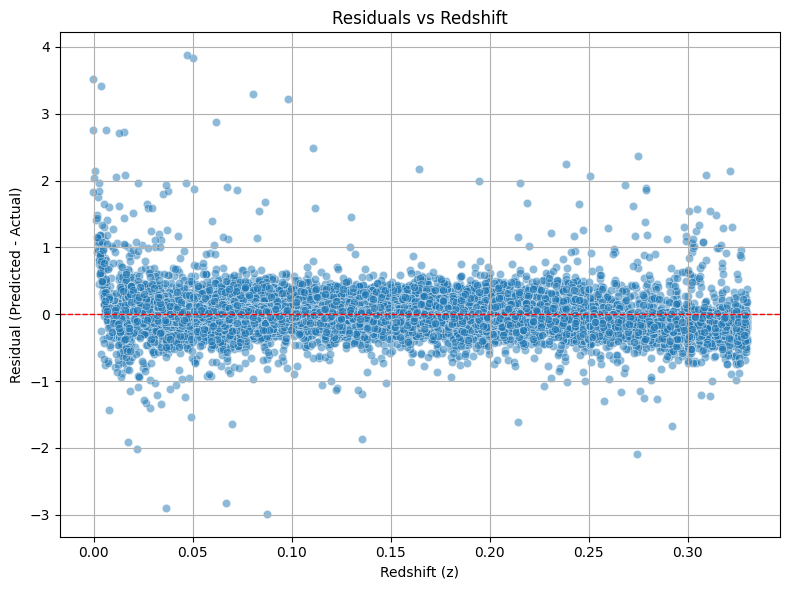

In [13]:
# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_test, x='z', y='residual', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Redshift (z)")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residuals vs Redshift")
plt.grid(True)
plt.tight_layout()
plt.show()


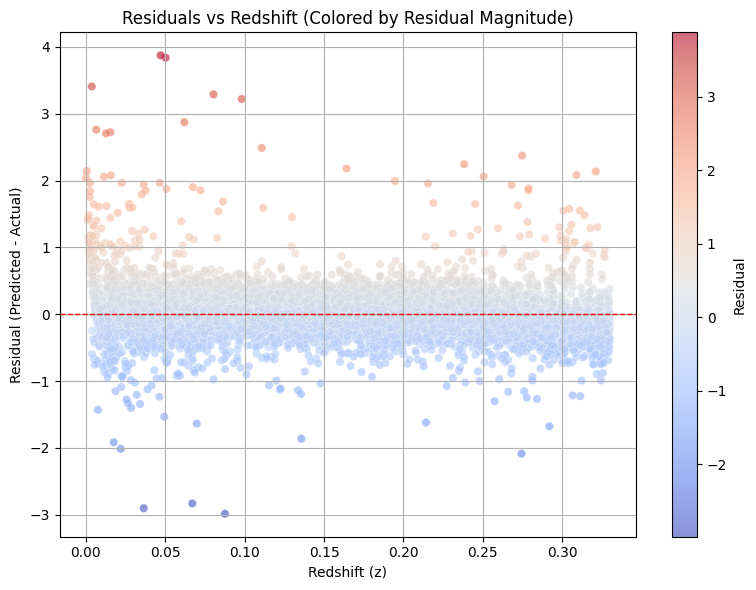

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter invalid redshifts
X_test = df[df['z'] > 0].copy()

# Calculate residuals
X_test['residual'] = y_pred_full - y_test

# Plot with residuals mapped to color
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_test['z'],
    X_test['residual'],
    c=X_test['residual'],      # Color by residual value
    cmap='coolwarm',             # Or try 'viridis', 'plasma', 'Spectral'
    alpha=0.6,
    edgecolors='w',
    linewidth=0.3
)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Redshift (z)")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residuals vs Redshift (Colored by Residual Magnitude)")
plt.colorbar(scatter, label='Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
X_test_scaled.shape, X_test.shape

((66855, 43), (66855, 43))

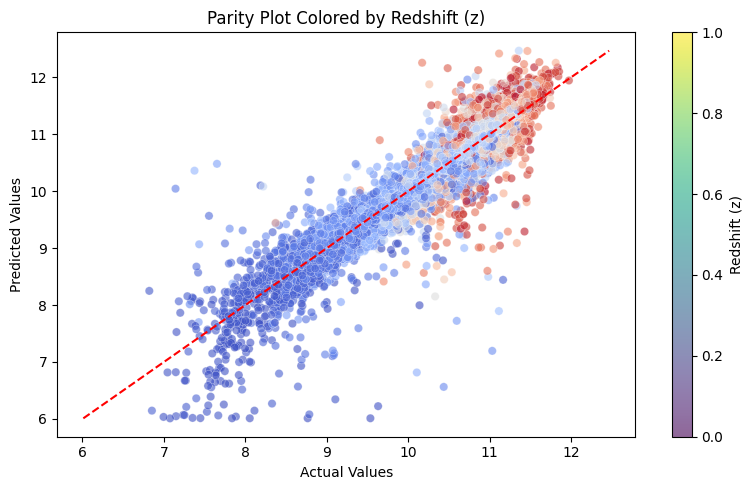

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_flat = y_pred_full.ravel()
y_test_flat = y_test.iloc[:, 0].values.ravel()

plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(
    x=y_pred_flat,
    y=y_test_flat,
    hue=X_test['z'],         # Assuming z_test_flat aligns with the test data
    palette='coolwarm',       # Try 'coolwarm', 'plasma', or 'Spectral' for variations
    alpha=0.6,
    edgecolor='w',
    linewidth=0.3,
    legend=False              # Set to True to include a legend
)

# Plot parity reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Labels and layout
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot Colored by Redshift (z)")
plt.colorbar(scatter.collections[0], label='Redshift (z)')
plt.tight_layout()
plt.show()

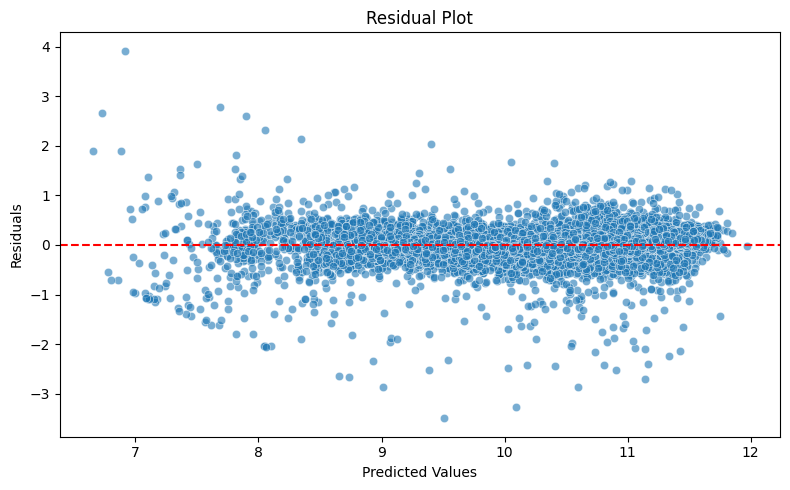

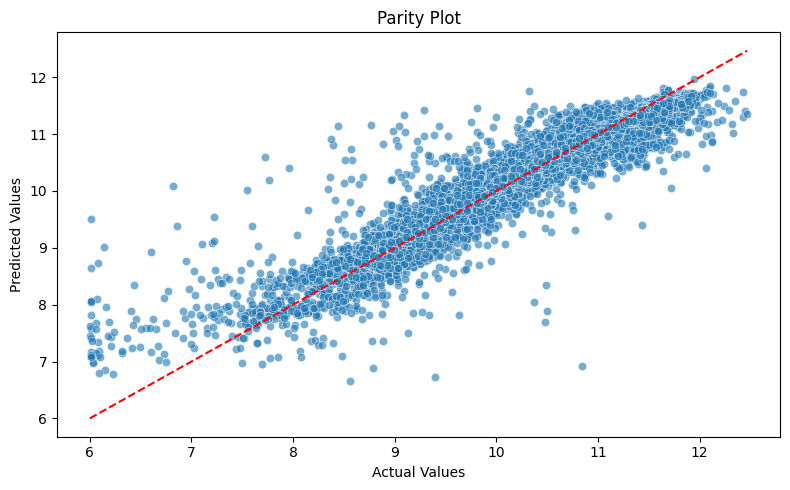

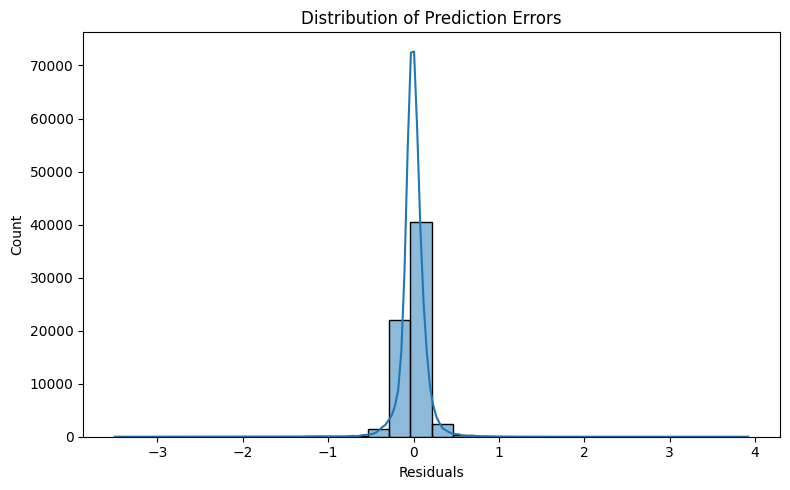

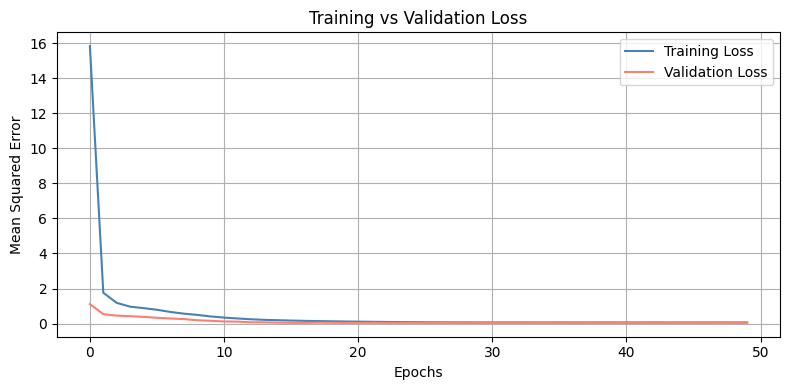

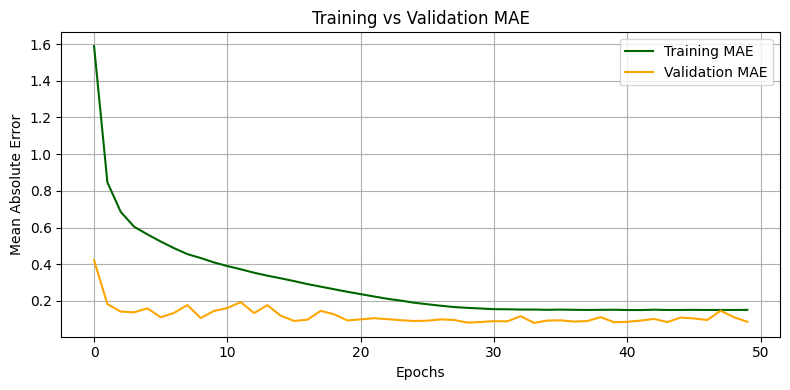

In [16]:
plot_visualizations(history, y_test, y_pred_full)

In [17]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[spectro_cols + photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [18]:
X_unseen_scaled = scaler.transform(X_unseen)

In [19]:
y_pred_unseen = model.predict(X_unseen_scaled)

6980/6980 [==============================] - 8s 1ms/step


In [20]:
plot_metrics(y_unseen, y_pred_unseen)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0937
Root Mean Squared Error (RMSE): 0.1618
R² Score: 0.9388


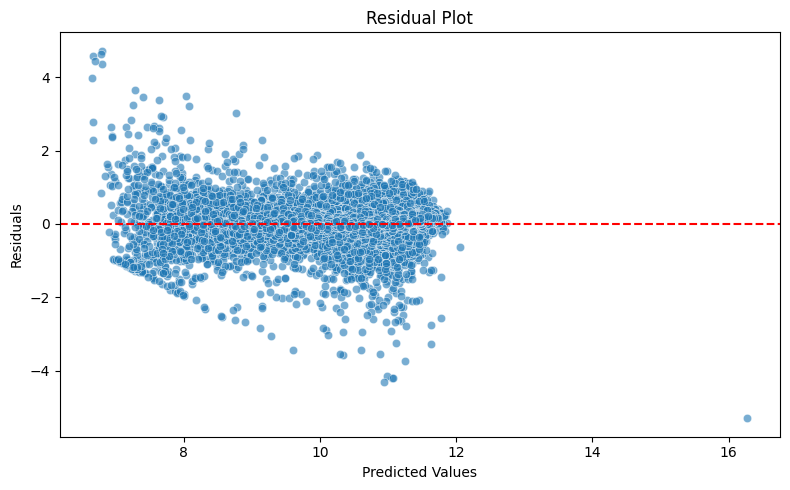

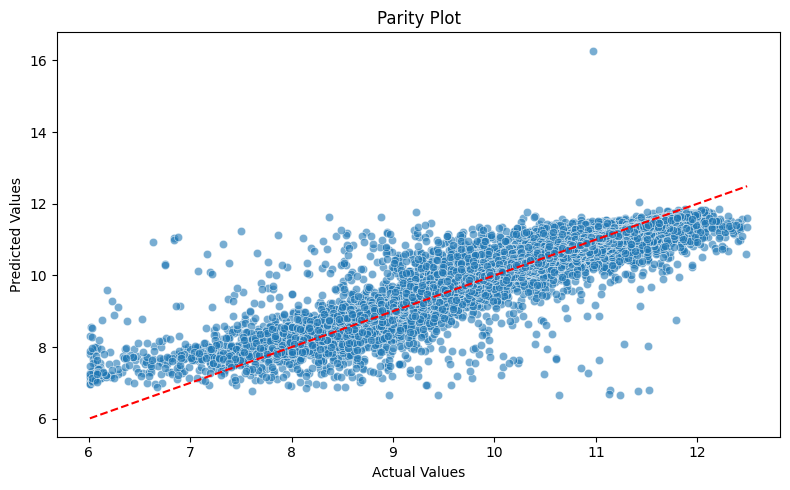

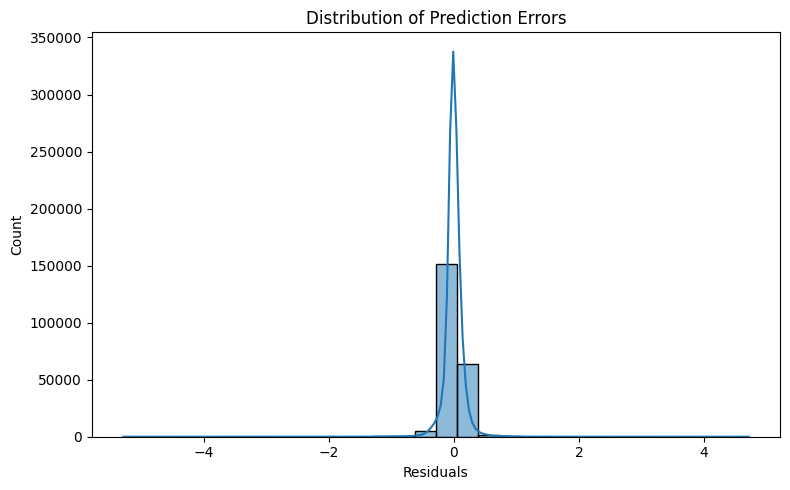

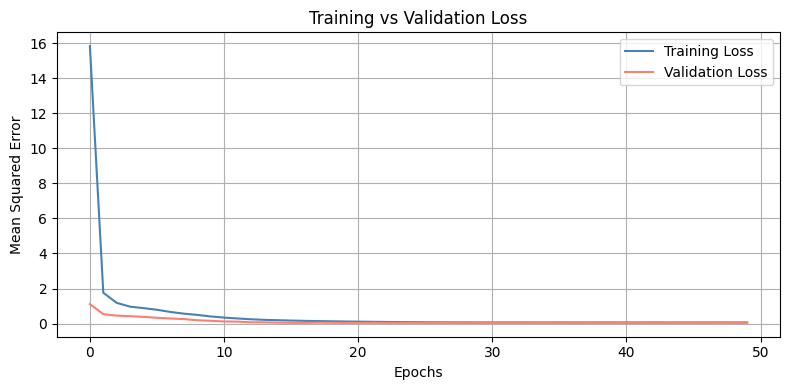

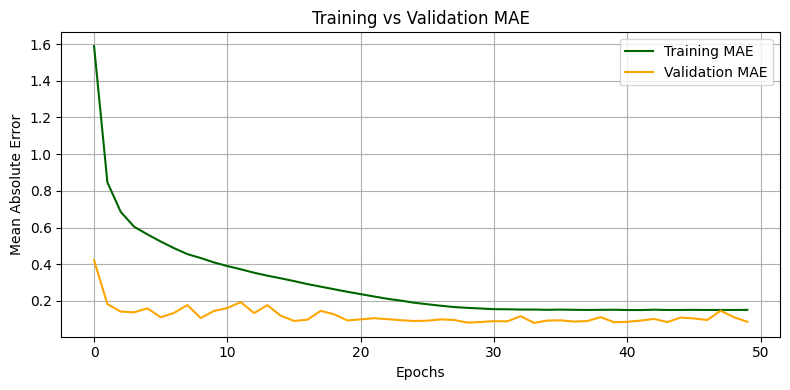

: 

In [ ]:
plot_visualizations(history, y_unseen, y_pred_unseen)